# Ablation vs Steering Comparison

Systematic comparison of intervention methods on hint-following behavior.

## Interventions
1. **Baseline** - No intervention
2. **Ablation** - Zero out activations at target location
3. **Steering** - Add steering vector (hint - baseline difference)

## Metrics
- **Candidate accuracy**: argmax over {correct, wrong_±1, wrong_±2} equals correct
- **Δ (delta)**: log P(correct) - max log P(wrong)
- **E_hint**: Δ_hint - Δ_baseline (hint effect size)
- **DD**: (Δ_hint - Δ_hint_int) - (Δ_baseline - Δ_baseline_int) (hint-specific causal effect)

## Target Locations
- Q layers: [0, 20, 21]
- Attention (o_proj output): [0, 20, 21]
- MLP layers: [1, 8, 9, 11, 27]
- Residual: [0, 1, 8, 9, 10, 11, 12, 20, 21, 22, 27]

## 1. Setup

In [24]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Paths
MODEL = "Qwen/Qwen3-0.6B"
LOGPROBS_FILE = "hint_variants/top-70-of-200_variant-count-10_with_logprobs.jsonl"
STEERING_VECTORS_DIR = Path("steering_vectors")

In [25]:
# Load model
tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="sdpa",
)
model.eval()

NUM_HEADS = model.config.num_attention_heads
HEAD_DIM = model.config.hidden_size // NUM_HEADS
NUM_LAYERS = model.config.num_hidden_layers
HIDDEN_SIZE = model.config.hidden_size

print(f"Model: {MODEL}")
print(f"Layers: {NUM_LAYERS}, Heads: {NUM_HEADS}, Head dim: {HEAD_DIM}, Hidden: {HIDDEN_SIZE}")

Model: Qwen/Qwen3-0.6B
Layers: 28, Heads: 16, Head dim: 64, Hidden: 1024


## 2. Load Data

In [ ]:
# Load and filter target problems
from src import load_jsonl_results

rollouts = load_jsonl_results(LOGPROBS_FILE)

# Group by problem
by_problem = {}
for r in rollouts:
    idx = r["problem_idx"]
    variant_idx = r.get("variant_idx", None)
    if (idx, variant_idx) not in by_problem:
        by_problem[(idx, variant_idx)] = {}
    by_problem[(idx, variant_idx)][r["mode"]] = r

# Filter: baseline prefers wrong, hint prefers correct
target_problems = []
for problem_idx, modes in by_problem.items():
    if "baseline" not in modes or "hint_correct_silent" not in modes:
        continue
    
    baseline = modes["baseline"]
    hint = modes["hint_correct_silent"]
    correct_answer = baseline["correct_answer"]
    
    # Filter: same digit count for answer +/- 2
    answer_digits = len(str(correct_answer))
    offsets = [-2, -1, 1, 2]
    all_same_digits = all(
        len(str(correct_answer + offset)) == answer_digits and (correct_answer + offset) > 0
        for offset in offsets
    )
    if not all_same_digits:
        continue
    
    # Get before_think checkpoint
    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    
    if baseline_cp is None or hint_cp is None:
        continue
    
    baseline_probs = baseline_cp["cand_softmax"]
    hint_probs = hint_cp["cand_softmax"]
    
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0]
    hint_best = max(hint_probs.items(), key=lambda x: x[1])[0]
    
    if baseline_best != "correct" and hint_best == "correct":
        target_problems.append({
            "problem_idx": problem_idx[0],
            "variant_idx": problem_idx[1],
            "question": baseline["question"],
            "correct_answer": correct_answer,
            "hint_value": hint["hint_value"],
            "baseline_prompt": baseline["prompt"],
            "hint_prompt": hint["prompt"],
        })

print(f"Loaded {len(target_problems)} target problems")

Loaded 633 target problems


## 3. Core Functions

In [27]:
def compute_readout_pos(prompt_text):
    """Compute readout position (last token of prompt + '\nAnswer: ')"""
    full_prompt = prompt_text + "\nAnswer: "
    prompt_ids = tok.encode(full_prompt, add_special_tokens=False)
    return len(prompt_ids) - 1


@torch.inference_mode()
def compute_answer_logprobs(context_token_ids, correct_answer, hint_value=None):
    """
    Compute logprobs for candidate answers.
    Returns dict with logp_correct, logp_wrong_max, delta, accuracy.
    """
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prefix_ids = context_token_ids + answer_prefix_ids
    prefix_len = len(prefix_ids)

    # Build candidates
    candidates = {"correct": correct_answer}
    for offset in [-2, -1, 1, 2]:
        val = correct_answer + offset
        if val > 0:
            candidates[f"wrong_{offset:+d}"] = val
    if hint_value is not None and hint_value != correct_answer:
        candidates["hint"] = hint_value

    cand_names = list(candidates.keys())
    cand_token_lists = [tok.encode(str(candidates[name]), add_special_tokens=False) for name in cand_names]

    # Batch sequences
    seqs = [prefix_ids + cand_ids for cand_ids in cand_token_lists]
    max_len = max(len(s) for s in seqs)

    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    input_ids = torch.full((len(seqs), max_len), pad_id, device=model.device, dtype=torch.long)
    attention_mask = torch.zeros((len(seqs), max_len), device=model.device, dtype=torch.long)

    for i, s in enumerate(seqs):
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, device=model.device)
        attention_mask[i, :L] = 1

    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    # Score each candidate
    results = {}
    for b, name in enumerate(cand_names):
        cand_ids = cand_token_lists[b]
        if len(cand_ids) == 0:
            results[name] = float("-inf")
            continue

        total = 0.0
        for j, tok_id in enumerate(cand_ids):
            pos = prefix_len + j - 1
            lp = torch.log_softmax(logits[b, pos], dim=-1)[tok_id]
            total += lp.item()
        results[name] = total

    # Compute metrics
    wrong_logprobs = [v for k, v in results.items() if k.startswith("wrong_")]
    wrong_max = max(wrong_logprobs) if wrong_logprobs else float("-inf")
    
    # Accuracy: is correct the argmax among numeric candidates?
    numeric_candidates = {k: v for k, v in results.items() if k != "hint"}
    argmax_cand = max(numeric_candidates.items(), key=lambda x: x[1])[0]
    accuracy = 1.0 if argmax_cand == "correct" else 0.0
    
    return {
        "logp_correct": results["correct"],
        "logp_wrong_max": wrong_max,
        "delta": results["correct"] - wrong_max,
        "accuracy": accuracy,
        "all_logprobs": results,
    }

In [28]:
def clear_all_hooks():
    """Clear all hooks from model"""
    model.model.embed_tokens._forward_hooks.clear()
    for layer_idx in range(NUM_LAYERS):
        layer = model.model.layers[layer_idx]
        layer._forward_pre_hooks.clear()
        layer._forward_hooks.clear()
        layer.self_attn._forward_hooks.clear()
        layer.self_attn._forward_pre_hooks.clear()
        layer.self_attn.q_proj._forward_hooks.clear()
        layer.self_attn.q_proj._forward_pre_hooks.clear()
        layer.self_attn.o_proj._forward_hooks.clear()
        layer.self_attn.o_proj._forward_pre_hooks.clear()
        layer.mlp._forward_hooks.clear()
        layer.mlp._forward_pre_hooks.clear()
    # Also clear final norm if present
    if hasattr(model.model, 'norm'):
        model.model.norm._forward_hooks.clear()
        model.model.norm._forward_pre_hooks.clear()

In [29]:
def setup_ablation_hook(location_type, layer_idx, readout_pos):
    """
    Setup hook to ZERO OUT activations at readout_pos (ablation).
    Returns hook handle.
    """
    if location_type == "residual":
        def hook(module, args):
            if len(args) > 0:
                hidden_states = args[0].clone()
                hidden_states[:, readout_pos, :] = 0
                return (hidden_states,) + args[1:]
            return args
        
        if layer_idx == 0:
            def hook_embed(module, args, output):
                out = output.clone()
                out[:, readout_pos, :] = 0
                return out
            return model.model.embed_tokens.register_forward_hook(hook_embed)
        elif layer_idx >= NUM_LAYERS:
            # Post final layer - hook the norm input
            def hook_norm(module, args):
                if len(args) > 0:
                    hidden_states = args[0].clone()
                    hidden_states[:, readout_pos, :] = 0
                    return (hidden_states,) + args[1:]
                return args
            return model.model.norm.register_forward_pre_hook(hook_norm)
        else:
            return model.model.layers[layer_idx].register_forward_pre_hook(hook)
    
    elif location_type == "mlp":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] = 0
            return out
        return model.model.layers[layer_idx].mlp.register_forward_hook(hook)
    
    elif location_type == "attention":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] = 0
            return out
        return model.model.layers[layer_idx].self_attn.o_proj.register_forward_hook(hook)
    
    elif location_type == "q_layer":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] = 0
            return out
        return model.model.layers[layer_idx].self_attn.q_proj.register_forward_hook(hook)
    
    else:
        raise ValueError(f"Unknown location_type: {location_type}")

In [30]:
def setup_steering_hook(location_type, layer_idx, readout_pos, steering_vector):
    """
    Setup hook to ADD steering vector at readout_pos.
    Returns hook handle.
    """
    if location_type == "residual":
        def hook(module, args):
            if len(args) > 0:
                hidden_states = args[0].clone()
                hidden_states[:, readout_pos, :] += steering_vector.to(hidden_states.device)
                return (hidden_states,) + args[1:]
            return args
        
        if layer_idx == 0:
            def hook_embed(module, args, output):
                out = output.clone()
                out[:, readout_pos, :] += steering_vector.to(out.device)
                return out
            return model.model.embed_tokens.register_forward_hook(hook_embed)
        elif layer_idx >= NUM_LAYERS:
            def hook_norm(module, args):
                if len(args) > 0:
                    hidden_states = args[0].clone()
                    hidden_states[:, readout_pos, :] += steering_vector.to(hidden_states.device)
                    return (hidden_states,) + args[1:]
                return args
            return model.model.norm.register_forward_pre_hook(hook_norm)
        else:
            return model.model.layers[layer_idx].register_forward_pre_hook(hook)
    
    elif location_type == "mlp":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].mlp.register_forward_hook(hook)
    
    elif location_type == "attention":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].self_attn.o_proj.register_forward_hook(hook)
    
    elif location_type == "q_layer":
        def hook(module, args, output):
            out = output.clone()
            out[:, readout_pos, :] += steering_vector.to(out.device)
            return out
        return model.model.layers[layer_idx].self_attn.q_proj.register_forward_hook(hook)
    
    else:
        raise ValueError(f"Unknown location_type: {location_type}")

In [31]:
def load_steering_vector(location_type, layer_idx):
    """
    Load steering vector from disk.
    File naming: {location_type}/{location_type}_L{layer_idx}.json
    """
    filepath = STEERING_VECTORS_DIR / location_type / f"{location_type}_L{layer_idx}.json"
    
    if not filepath.exists():
        return None, None
    
    with open(filepath, "r") as f:
        data = json.load(f)
    
    vector = torch.tensor(data["vector"])
    metadata = data["metadata"]
    
    return vector, metadata

## 4. Experiment Runner

In [32]:
@torch.inference_mode()
def run_experiment(location_type, layer_idx, intervention_type, alpha=1.0, n_problems=None):
    """
    Run experiment with specified intervention.
    
    Args:
        location_type: "residual", "mlp", "attention", "q_layer", "o_proj_layer"
        layer_idx: Layer index
        intervention_type: "none", "ablation", "steering"
        alpha: Steering strength (only for steering)
        n_problems: Limit number of problems (for testing)
    
    Returns:
        List of result dicts
    """
    # Load steering vector if needed
    steering_vector = None
    if intervention_type == "steering":
        steering_vector, metadata = load_steering_vector(location_type, layer_idx)
        if steering_vector is None:
            print(f"Warning: No steering vector for {location_type} L{layer_idx}")
            return None
        steering_vector = steering_vector * alpha  # Scale by alpha
    
    problems = target_problems[:n_problems] if n_problems else target_problems
    results = []
    
    desc = f"{intervention_type} {location_type} L{layer_idx}"
    if intervention_type == "steering":
        desc += f" (α={alpha})"
    
    for tp in tqdm(problems, desc=desc):
        baseline_prompt_ids = tok.encode(tp["baseline_prompt"], add_special_tokens=False)
        hint_prompt_ids = tok.encode(tp["hint_prompt"], add_special_tokens=False)
        baseline_readout_pos = compute_readout_pos(tp["baseline_prompt"])
        hint_readout_pos = compute_readout_pos(tp["hint_prompt"])
        
        # Baseline condition (no intervention)
        clear_all_hooks()
        baseline_result = compute_answer_logprobs(baseline_prompt_ids, tp["correct_answer"], None)
        
        # Hint condition (no intervention)
        clear_all_hooks()
        hint_result = compute_answer_logprobs(hint_prompt_ids, tp["correct_answer"], tp["hint_value"])
        
        # Baseline with intervention
        clear_all_hooks()
        if intervention_type == "ablation":
            handle = setup_ablation_hook(location_type, layer_idx, baseline_readout_pos)
        elif intervention_type == "steering":
            handle = setup_steering_hook(location_type, layer_idx, baseline_readout_pos, steering_vector)
        else:
            handle = None
        baseline_int_result = compute_answer_logprobs(baseline_prompt_ids, tp["correct_answer"], None)
        if handle:
            handle.remove()
        
        # Hint with intervention
        clear_all_hooks()
        if intervention_type == "ablation":
            handle = setup_ablation_hook(location_type, layer_idx, hint_readout_pos)
        elif intervention_type == "steering":
            handle = setup_steering_hook(location_type, layer_idx, hint_readout_pos, steering_vector)
        else:
            handle = None
        hint_int_result = compute_answer_logprobs(hint_prompt_ids, tp["correct_answer"], tp["hint_value"])
        if handle:
            handle.remove()
        
        clear_all_hooks()
        
        # Store results
        results.append({
            "problem_idx": tp["problem_idx"],
            "variant_idx": tp["variant_idx"],
            "location_type": location_type,
            "layer_idx": layer_idx,
            "intervention_type": intervention_type,
            "alpha": alpha if intervention_type == "steering" else None,
            # Raw deltas
            "delta_baseline": baseline_result["delta"],
            "delta_hint": hint_result["delta"],
            "delta_baseline_int": baseline_int_result["delta"],
            "delta_hint_int": hint_int_result["delta"],
            # Accuracies
            "acc_baseline": baseline_result["accuracy"],
            "acc_hint": hint_result["accuracy"],
            "acc_baseline_int": baseline_int_result["accuracy"],
            "acc_hint_int": hint_int_result["accuracy"],
        })
    
    return results

In [33]:
def compute_metrics(results):
    """
    Compute derived metrics from raw results.
    """
    for r in results:
        # E_hint: hint effect (how much hint helps)
        r["E_hint"] = r["delta_hint"] - r["delta_baseline"]
        
        # Baseline damage: how much intervention hurts baseline
        r["baseline_damage"] = r["delta_baseline"] - r["delta_baseline_int"]
        
        # Hint damage: how much intervention hurts hint
        r["hint_damage"] = r["delta_hint"] - r["delta_hint_int"]
        
        # DD: difference-in-differences (hint-specific effect)
        r["DD"] = r["hint_damage"] - r["baseline_damage"]
        
        # DD/E_hint ratio (selectivity - only meaningful when E_hint > 0)
        if r["E_hint"] > 0.1:  # threshold to avoid division issues
            r["DD_ratio"] = r["DD"] / r["E_hint"]
        else:
            r["DD_ratio"] = None
    
    return results


def summarize_results(results):
    """
    Compute summary statistics from results.
    """
    if not results:
        return None
    
    results = compute_metrics(results)
    
    # Filter for valid DD_ratio
    valid_dd = [r["DD_ratio"] for r in results if r["DD_ratio"] is not None]
    
    return {
        "n": len(results),
        "location_type": results[0]["location_type"],
        "layer_idx": results[0]["layer_idx"],
        "intervention_type": results[0]["intervention_type"],
        "alpha": results[0]["alpha"],
        # Accuracies
        "acc_baseline": np.mean([r["acc_baseline"] for r in results]),
        "acc_hint": np.mean([r["acc_hint"] for r in results]),
        "acc_baseline_int": np.mean([r["acc_baseline_int"] for r in results]),
        "acc_hint_int": np.mean([r["acc_hint_int"] for r in results]),
        # Deltas
        "mean_delta_baseline": np.mean([r["delta_baseline"] for r in results]),
        "mean_delta_hint": np.mean([r["delta_hint"] for r in results]),
        "mean_delta_baseline_int": np.mean([r["delta_baseline_int"] for r in results]),
        "mean_delta_hint_int": np.mean([r["delta_hint_int"] for r in results]),
        # Derived metrics
        "mean_E_hint": np.mean([r["E_hint"] for r in results]),
        "mean_baseline_damage": np.mean([r["baseline_damage"] for r in results]),
        "mean_hint_damage": np.mean([r["hint_damage"] for r in results]),
        "mean_DD": np.mean([r["DD"] for r in results]),
        "mean_DD_ratio": np.mean(valid_dd) if valid_dd else None,
        "std_DD": np.std([r["DD"] for r in results]),
    }

## 5. Run Experiments

- **Ablation**: Single cell, runs all locations
- **Steering**: One cell per location type - tweak alphas at top of each cell and run

In [34]:
# Results storage (run once)
ablation_results = []
ablation_summaries = []
steering_results = []
steering_summaries = []

def add_steering_results(results, summaries):
    """Helper to accumulate steering results"""
    steering_results.extend(results)
    steering_summaries.extend(summaries)

In [35]:
# Quick sanity check
test = run_experiment("mlp", 11, "ablation", n_problems=5)
if test:
    s = summarize_results(test)
    print(f"Sanity check OK: E_hint={s['mean_E_hint']:.3f}, DD={s['mean_DD']:.3f}")

ablation mlp L11: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

Sanity check OK: E_hint=7.209, DD=-0.381


In [36]:
# ============================================
# ABLATION (all locations)
# ============================================
ABLATION_TARGETS = {
    "q_layer": [0, 20, 21],
    "attention": [0, 20, 21],
    "mlp": [1, 8, 9, 11, 27],
    "residual": [0, 1, 8, 9, 10, 11, 12, 20, 21, 22, 27],
}

ablation_results = []
ablation_summaries = []

for loc_type, layers in ABLATION_TARGETS.items():
    for layer in layers:
        results = run_experiment(loc_type, layer, "ablation")
        if results:
            ablation_results.extend(results)
            summary = summarize_results(results)
            ablation_summaries.append(summary)
            print(f"{loc_type:12} L{layer:2}: DD={summary['mean_DD']:+.3f}  base_dmg={summary['mean_baseline_damage']:+.3f}")

print(f"\n=== Ablation done: {len(ablation_summaries)} experiments ===")

ablation q_layer L0: 100%|██████████| 633/633 [03:15<00:00,  3.24it/s]


q_layer      L 0: DD=+1.340  base_dmg=-0.508


ablation q_layer L20: 100%|██████████| 633/633 [03:01<00:00,  3.49it/s]


q_layer      L20: DD=+0.021  base_dmg=+0.014


ablation q_layer L21: 100%|██████████| 633/633 [03:12<00:00,  3.29it/s]


q_layer      L21: DD=+0.055  base_dmg=+0.026


ablation attention L0: 100%|██████████| 633/633 [03:13<00:00,  3.27it/s]


attention    L 0: DD=+1.704  base_dmg=-0.406


ablation attention L20: 100%|██████████| 633/633 [03:02<00:00,  3.47it/s]


attention    L20: DD=-0.005  base_dmg=-0.017


ablation attention L21: 100%|██████████| 633/633 [02:46<00:00,  3.79it/s]


attention    L21: DD=+0.112  base_dmg=+0.004


ablation mlp L1: 100%|██████████| 633/633 [03:13<00:00,  3.27it/s]


mlp          L 1: DD=+0.388  base_dmg=-0.044


ablation mlp L8: 100%|██████████| 633/633 [03:07<00:00,  3.37it/s]


mlp          L 8: DD=+0.218  base_dmg=-0.091


ablation mlp L9: 100%|██████████| 633/633 [03:10<00:00,  3.32it/s]


mlp          L 9: DD=+0.481  base_dmg=-0.052


ablation mlp L11: 100%|██████████| 633/633 [03:11<00:00,  3.31it/s]


mlp          L11: DD=-0.581  base_dmg=+0.001


ablation mlp L27: 100%|██████████| 633/633 [03:07<00:00,  3.38it/s]


mlp          L27: DD=+0.000  base_dmg=+0.000


ablation residual L0: 100%|██████████| 633/633 [03:07<00:00,  3.38it/s]


residual     L 0: DD=+1.473  base_dmg=-0.593


ablation residual L1: 100%|██████████| 633/633 [03:01<00:00,  3.49it/s]


residual     L 1: DD=+1.527  base_dmg=-0.279


ablation residual L8: 100%|██████████| 633/633 [02:57<00:00,  3.58it/s]


residual     L 8: DD=+0.158  base_dmg=-0.190


ablation residual L9: 100%|██████████| 633/633 [03:12<00:00,  3.29it/s]


residual     L 9: DD=+0.015  base_dmg=-0.089


ablation residual L10: 100%|██████████| 633/633 [03:16<00:00,  3.23it/s]


residual     L10: DD=-0.064  base_dmg=-0.009


ablation residual L11: 100%|██████████| 633/633 [03:09<00:00,  3.35it/s]


residual     L11: DD=-0.128  base_dmg=+0.106


ablation residual L12: 100%|██████████| 633/633 [03:06<00:00,  3.40it/s]


residual     L12: DD=-0.004  base_dmg=-0.075


ablation residual L20: 100%|██████████| 633/633 [02:44<00:00,  3.85it/s]


residual     L20: DD=+0.583  base_dmg=-0.049


ablation residual L21: 100%|██████████| 633/633 [02:28<00:00,  4.25it/s]


residual     L21: DD=+0.156  base_dmg=-0.026


ablation residual L22: 100%|██████████| 633/633 [02:40<00:00,  3.95it/s]


residual     L22: DD=+0.162  base_dmg=+0.008


ablation residual L27: 100%|██████████| 633/633 [02:51<00:00,  3.69it/s]

residual     L27: DD=+0.087  base_dmg=+0.001

=== Ablation done: 22 experiments ===


In [65]:
# ============================================
# TEST SINGLE STEERING VECTOR
# ============================================
LOC_TYPE = "mlp"      # <- change: "mlp", "attention", "q_layer", "residual"
LAYER = 9             # <- change
ALPHAS = [-25, -20, -15, 15, 20, 25]  # <- tweak
N_PROBLEMS = 100     # <- set to 50 for faster testing, None for all

# Output path
OUTPUT_DIR = Path("steering_vs_ablation_metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

# Run
vec, _ = load_steering_vector(LOC_TYPE, LAYER)
if vec is None:
    print(f"No vector for {LOC_TYPE} L{LAYER}")
else:
    print(f"Testing {LOC_TYPE} L{LAYER}\n")
    print(f"{'α':>8} | {'DD':>7} | {'base_dmg':>9} | {'hint_dmg':>9} | {'acc_hint':>8}")
    print("-" * 55)
    
    # Collect results
    all_summaries = []
    
    for alpha in ALPHAS:
        r = run_experiment(LOC_TYPE, LAYER, "steering", alpha=alpha, n_problems=N_PROBLEMS)
        if r:
            s = summarize_results(r)
            all_summaries.append(s)
            print(f"{alpha:+8.1f} | {s['mean_DD']:+7.3f} | {s['mean_baseline_damage']:+9.3f} | "
                  f"{s['mean_hint_damage']:+9.3f} | {s['acc_hint_int']:7.1%}")
    
    # Save results
    output_file = OUTPUT_DIR / f"{LOC_TYPE}_L{LAYER}_n{N_PROBLEMS}.jsonl"
    with open(output_file, "a") as f:
        for summary in all_summaries:
            f.write(json.dumps(summary) + "\n")
    
    print(f"\n✓ Saved to: {output_file}")
    print(f"Tested {len(all_summaries)} alpha values on {N_PROBLEMS} problems")

Testing mlp L9

       α |      DD |  base_dmg |  hint_dmg | acc_hint
-------------------------------------------------------


steering mlp L9 (α=-25): 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


   -25.0 |  -0.258 |    +0.365 |    +0.107 |   96.0%


steering mlp L9 (α=-20): 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


   -20.0 |  -0.195 |    +0.317 |    +0.123 |   97.0%


steering mlp L9 (α=-15): 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


   -15.0 |  -0.202 |    +0.271 |    +0.069 |   98.0%


steering mlp L9 (α=15): 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


   +15.0 |  -1.653 |    +0.513 |    -1.140 |   99.0%


steering mlp L9 (α=20): 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


   +20.0 |  -1.773 |    +0.819 |    -0.954 |   97.0%


steering mlp L9 (α=25): 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]

   +25.0 |  -1.619 |    +0.946 |    -0.673 |   94.0%

✓ Saved to: steering_vs_ablation_metrics/mlp_L9_n100.jsonl
Tested 6 alpha values on 100 problems


In [51]:
# ============================================
# TEST SINGLE STEERING VECTOR
# ============================================
LOC_TYPE = "mlp"      # <- change: "mlp", "attention", "q_layer", "residual"
LAYER = 11           # <- change
ALPHAS = [-30, -25, -20, -15, 15, 20, 25, 30]  # <- tweak
N_PROBLEMS = 100     # <- set to 50 for faster testing, None for all

# Output path
OUTPUT_DIR = Path("steering_vs_ablation_metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

# Run
vec, _ = load_steering_vector(LOC_TYPE, LAYER)
if vec is None:
    print(f"No vector for {LOC_TYPE} L{LAYER}")
else:
    print(f"Testing {LOC_TYPE} L{LAYER}\n")
    print(f"{'α':>8} | {'DD':>7} | {'base_dmg':>9} | {'hint_dmg':>9} | {'acc_hint':>8}")
    print("-" * 55)
    
    # Collect results
    all_summaries = []
    
    for alpha in ALPHAS:
        r = run_experiment(LOC_TYPE, LAYER, "steering", alpha=alpha, n_problems=N_PROBLEMS)
        if r:
            s = summarize_results(r)
            all_summaries.append(s)
            print(f"{alpha:+8.1f} | {s['mean_DD']:+7.3f} | {s['mean_baseline_damage']:+9.3f} | "
                  f"{s['mean_hint_damage']:+9.3f} | {s['acc_hint_int']:7.1%}")
    
    # Save results
    output_file = OUTPUT_DIR / f"{LOC_TYPE}_L{LAYER}_n{N_PROBLEMS}.jsonl"
    with open(output_file, "a") as f:
        for summary in all_summaries:
            f.write(json.dumps(summary) + "\n")
    
    print(f"\n✓ Saved to: {output_file}")
    print(f"Tested {len(all_summaries)} alpha values on {N_PROBLEMS} problems")

Testing mlp L11

       α |      DD |  base_dmg |  hint_dmg | acc_hint
-------------------------------------------------------


steering mlp L11 (α=-30): 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


   -30.0 |  -0.197 |    -0.049 |    -0.246 |   97.0%


steering mlp L11 (α=-25): 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


   -25.0 |  -0.100 |    -0.061 |    -0.162 |   97.0%


steering mlp L11 (α=-20): 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


   -20.0 |  -0.034 |    -0.075 |    -0.109 |   98.0%


steering mlp L11 (α=-15): 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


   -15.0 |  +0.040 |    -0.106 |    -0.066 |   98.0%


steering mlp L11 (α=15): 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


   +15.0 |  -0.424 |    +0.188 |    -0.236 |   99.0%


steering mlp L11 (α=20): 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


   +20.0 |  -0.649 |    +0.167 |    -0.483 |   98.0%


steering mlp L11 (α=25): 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


   +25.0 |  -0.904 |    +0.288 |    -0.616 |   98.0%


steering mlp L11 (α=30): 100%|██████████| 100/100 [00:13<00:00,  7.68it/s]

   +30.0 |  -1.024 |    +0.466 |    -0.558 |   97.0%

✓ Saved to: steering_vs_ablation_metrics/mlp_L11_n100.jsonl
Tested 8 alpha values on 100 problems


In [52]:
# ============================================
# TEST SINGLE STEERING VECTOR
# ============================================
LOC_TYPE = "attention"      # <- change: "mlp", "attention", "q_layer", "residual"
LAYER = 0           # <- change
ALPHAS = [-12, -10, -8, -6, -5, -2, -1, 1, 2, 5, 6, 8, 10, 12]  # <- tweak
N_PROBLEMS = 100     # <- set to 50 for faster testing, None for all

# Output path
OUTPUT_DIR = Path("steering_vs_ablation_metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

# Run
vec, _ = load_steering_vector(LOC_TYPE, LAYER)
if vec is None:
    print(f"No vector for {LOC_TYPE} L{LAYER}")
else:
    print(f"Testing {LOC_TYPE} L{LAYER}\n")
    print(f"{'α':>8} | {'DD':>7} | {'base_dmg':>9} | {'hint_dmg':>9} | {'acc_hint':>8}")
    print("-" * 55)
    
    # Collect results
    all_summaries = []
    
    for alpha in ALPHAS:
        r = run_experiment(LOC_TYPE, LAYER, "steering", alpha=alpha, n_problems=N_PROBLEMS)
        if r:
            s = summarize_results(r)
            all_summaries.append(s)
            print(f"{alpha:+8.1f} | {s['mean_DD']:+7.3f} | {s['mean_baseline_damage']:+9.3f} | "
                  f"{s['mean_hint_damage']:+9.3f} | {s['acc_hint_int']:7.1%}")
    
    # Save results
    output_file = OUTPUT_DIR / f"{LOC_TYPE}_L{LAYER}_n{N_PROBLEMS}.jsonl"
    with open(output_file, "a") as f:
        for summary in all_summaries:
            f.write(json.dumps(summary) + "\n")
    
    print(f"\n✓ Saved to: {output_file}")
    print(f"Tested {len(all_summaries)} alpha values on {N_PROBLEMS} problems")

Testing attention L0

       α |      DD |  base_dmg |  hint_dmg | acc_hint
-------------------------------------------------------


steering attention L0 (α=-12): 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


   -12.0 |  +0.465 |    -0.459 |    +0.006 |   97.0%


steering attention L0 (α=-10): 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


   -10.0 |  +0.413 |    -0.406 |    +0.007 |   97.0%


steering attention L0 (α=-8): 100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


    -8.0 |  +0.552 |    -0.381 |    +0.171 |   98.0%


steering attention L0 (α=-6): 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


    -6.0 |  +0.343 |    -0.272 |    +0.071 |   99.0%


steering attention L0 (α=-5): 100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


    -5.0 |  +0.325 |    -0.270 |    +0.055 |   99.0%


steering attention L0 (α=-2): 100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


    -2.0 |  +0.261 |    -0.156 |    +0.104 |   99.0%


steering attention L0 (α=-1): 100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


    -1.0 |  +0.055 |    -0.073 |    -0.019 |  100.0%


steering attention L0 (α=1): 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


    +1.0 |  +0.288 |    -0.130 |    +0.158 |   99.0%


steering attention L0 (α=2): 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


    +2.0 |  +0.428 |    -0.156 |    +0.273 |  100.0%


steering attention L0 (α=5): 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


    +5.0 |  +0.875 |    -0.169 |    +0.706 |   96.0%


steering attention L0 (α=6): 100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


    +6.0 |  +1.522 |    -0.437 |    +1.085 |   96.0%


steering attention L0 (α=8): 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


    +8.0 |  +1.109 |    -0.099 |    +1.010 |   96.0%


steering attention L0 (α=10): 100%|██████████| 100/100 [00:13<00:00,  7.58it/s]


   +10.0 |  +0.885 |    +0.019 |    +0.904 |   94.0%


steering attention L0 (α=12): 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]

   +12.0 |  +0.793 |    -0.098 |    +0.695 |   97.0%

✓ Saved to: steering_vs_ablation_metrics/attention_L0_n100.jsonl
Tested 14 alpha values on 100 problems


In [79]:
# ============================================
# TEST SINGLE STEERING VECTOR
# ============================================
LOC_TYPE = "residual"      # <- change: "mlp", "attention", "q_layer", "residual"
LAYER = 25          # <- change
ALPHAS = [-10, -5, 0, 5, 10]  # <- tweak
N_PROBLEMS = 100     # <- set to 50 for faster testing, None for all

# Output path
OUTPUT_DIR = Path("steering_vs_ablation_metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

# Run
vec, _ = load_steering_vector(LOC_TYPE, LAYER)
if vec is None:
    print(f"No vector for {LOC_TYPE} L{LAYER}")
else:
    print(f"Testing {LOC_TYPE} L{LAYER}\n")
    print(f"{'α':>8} | {'DD':>7} | {'base_dmg':>9} | {'hint_dmg':>9} | {'acc_hint':>8}")
    print("-" * 55)
    
    # Collect results
    all_summaries = []
    
    for alpha in ALPHAS:
        r = run_experiment(LOC_TYPE, LAYER, "steering", alpha=alpha, n_problems=N_PROBLEMS)
        if r:
            s = summarize_results(r)
            all_summaries.append(s)
            print(f"{alpha:+8.1f} | {s['mean_DD']:+7.3f} | {s['mean_baseline_damage']:+9.3f} | "
                  f"{s['mean_hint_damage']:+9.3f} | {s['acc_hint_int']:7.1%}")
    
    # Save results
    output_file = OUTPUT_DIR / f"{LOC_TYPE}_L{LAYER}_n{N_PROBLEMS}.jsonl"
    with open(output_file, "a") as f:
        for summary in all_summaries:
            f.write(json.dumps(summary) + "\n")
    
    print(f"\n✓ Saved to: {output_file}")
    print(f"Tested {len(all_summaries)} alpha values on {N_PROBLEMS} problems")

Testing residual L25

       α |      DD |  base_dmg |  hint_dmg | acc_hint
-------------------------------------------------------


steering residual L25 (α=-10): 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


   -10.0 |  +0.027 |    -0.014 |    +0.012 |  100.0%


steering residual L25 (α=-5): 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


    -5.0 |  +0.018 |    -0.007 |    +0.011 |   99.0%


steering residual L25 (α=0): 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


    +0.0 |  +0.000 |    +0.000 |    +0.000 |  100.0%


steering residual L25 (α=5): 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


    +5.0 |  +0.010 |    -0.023 |    -0.013 |  100.0%


steering residual L25 (α=10): 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]

   +10.0 |  -0.008 |    -0.014 |    -0.022 |  100.0%

✓ Saved to: steering_vs_ablation_metrics/residual_L25_n100.jsonl
Tested 5 alpha values on 100 problems


   location_type  layer_idx   mean_DD  mean_baseline_damage  mean_E_hint
0        q_layer          0  1.339933             -0.508019     5.343334
1        q_layer         20  0.021212              0.013680     5.343334
2        q_layer         21  0.054948              0.026056     5.343334
3      attention          0  1.703756             -0.405775     5.343334
4      attention         20 -0.005155             -0.016975     5.343334
5      attention         21  0.111520              0.003922     5.343334
6            mlp          1  0.388117             -0.044330     5.343334
7            mlp          8  0.217862             -0.091490     5.343334
8            mlp          9  0.480713             -0.052092     5.343334
9            mlp         11 -0.581056              0.000656     5.343334
10           mlp         27  0.000000              0.000000     5.343334
11      residual          0  1.473135             -0.592846     5.343334
12      residual          1  1.527236             -

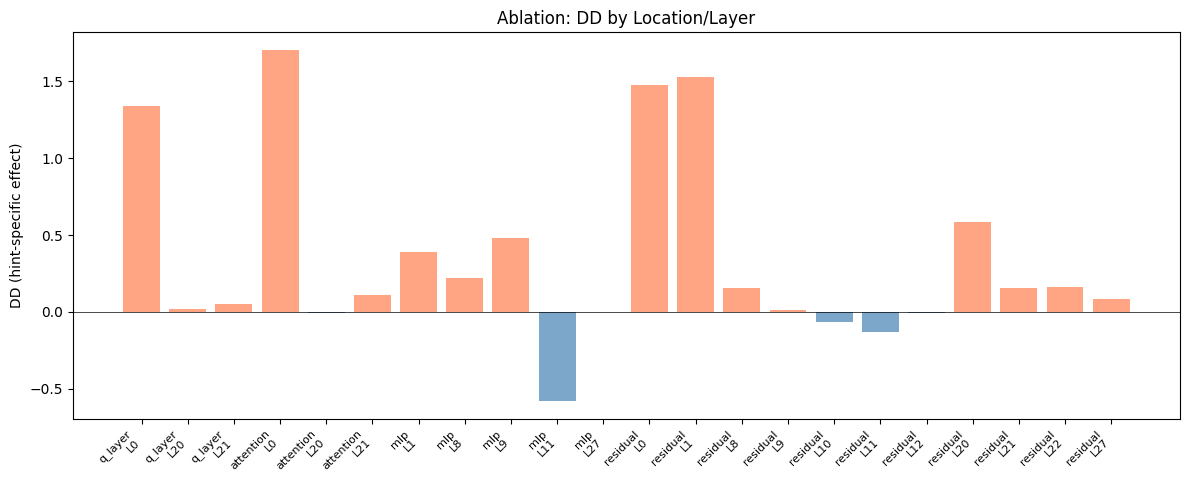

In [39]:
import pandas as pd
df_ablation = pd.DataFrame(ablation_summaries)

# Quick summary table
print(df_ablation[["location_type", "layer_idx", "mean_DD", "mean_baseline_damage", "mean_E_hint"]].to_string())

# Bar plot of DD by location/layer
fig, ax = plt.subplots(figsize=(12, 5))
labels = [f"{row['location_type']}\nL{int(row['layer_idx'])}" for _, row in df_ablation.iterrows()]
colors = ['coral' if row['mean_DD'] > 0 else 'steelblue' for _, row in df_ablation.iterrows()]
ax.bar(range(len(df_ablation)), df_ablation["mean_DD"], color=colors, alpha=0.7)
ax.set_xticks(range(len(df_ablation)))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax.set_ylabel("DD (hint-specific effect)")
ax.set_title("Ablation: DD by Location/Layer")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# STEERING: q_layer
# ============================================
LAYERS = [0, 20, 21]
ALPHAS = [1.0, 2.0, 5.0, 10.0]  # <-- TWEAK THIS

_results, _summaries = [], []
for layer in LAYERS:
    vec, _ = load_steering_vector("q_layer", layer)
    if vec is None:
        print(f"L{layer}: no vector"); continue
    for alpha in ALPHAS:
        r = run_experiment("q_layer", layer, "steering", alpha=alpha)
        if r:
            _results.extend(r)
            _summaries.append(summarize_results(r))
    # best for this layer
    layer_s = [s for s in _summaries if s["layer_idx"] == layer]
    if layer_s:
        best = max(layer_s, key=lambda x: x["mean_DD"])
        print(f"L{layer}: best α={best['alpha']:+.1f} -> DD={best['mean_DD']:+.3f}, base_dmg={best['mean_baseline_damage']:+.3f}")

add_steering_results(_results, _summaries)
print(f"q_layer steering done: {len(_summaries)} experiments")

In [ ]:
# ============================================
# STEERING: attention
# ============================================
LAYERS = [0, 20, 21]
ALPHAS = [1.0, 2.0, 5.0, 10.0]  # <-- TWEAK THIS

_results, _summaries = [], []
for layer in LAYERS:
    vec, _ = load_steering_vector("attention", layer)
    if vec is None:
        print(f"L{layer}: no vector"); continue
    for alpha in ALPHAS:
        r = run_experiment("attention", layer, "steering", alpha=alpha)
        if r:
            _results.extend(r)
            _summaries.append(summarize_results(r))
    # best for this layer
    layer_s = [s for s in _summaries if s["layer_idx"] == layer]
    if layer_s:
        best = max(layer_s, key=lambda x: x["mean_DD"])
        print(f"L{layer}: best α={best['alpha']:+.1f} -> DD={best['mean_DD']:+.3f}, base_dmg={best['mean_baseline_damage']:+.3f}")

add_steering_results(_results, _summaries)
print(f"attention steering done: {len(_summaries)} experiments")

In [ ]:
# ============================================
# STEERING: mlp
# ============================================
LAYERS = [1, 8, 9, 11, 27]
ALPHAS = [1.0, 2.0, 5.0, 10.0]  # <-- TWEAK THIS

_results, _summaries = [], []
for layer in LAYERS:
    vec, _ = load_steering_vector("mlp", layer)
    if vec is None:
        print(f"L{layer}: no vector"); continue
    for alpha in ALPHAS:
        r = run_experiment("mlp", layer, "steering", alpha=alpha)
        if r:
            _results.extend(r)
            _summaries.append(summarize_results(r))
    # best for this layer
    layer_s = [s for s in _summaries if s["layer_idx"] == layer]
    if layer_s:
        best = max(layer_s, key=lambda x: x["mean_DD"])
        print(f"L{layer}: best α={best['alpha']:+.1f} -> DD={best['mean_DD']:+.3f}, base_dmg={best['mean_baseline_damage']:+.3f}")

add_steering_results(_results, _summaries)
print(f"mlp steering done: {len(_summaries)} experiments")

In [ ]:
# ============================================
# STEERING: residual
# ============================================
LAYERS = [0, 1, 8, 9, 10, 11, 12, 20, 21, 22, 27]
ALPHAS = [1.0, 2.0, 5.0, 10.0]  # <-- TWEAK THIS

_results, _summaries = [], []
for layer in LAYERS:
    vec, _ = load_steering_vector("residual", layer)
    if vec is None:
        print(f"L{layer}: no vector"); continue
    for alpha in ALPHAS:
        r = run_experiment("residual", layer, "steering", alpha=alpha)
        if r:
            _results.extend(r)
            _summaries.append(summarize_results(r))
    # best for this layer
    layer_s = [s for s in _summaries if s["layer_idx"] == layer]
    if layer_s:
        best = max(layer_s, key=lambda x: x["mean_DD"])
        print(f"L{layer}: best α={best['alpha']:+.1f} -> DD={best['mean_DD']:+.3f}, base_dmg={best['mean_baseline_damage']:+.3f}")

add_steering_results(_results, _summaries)
print(f"residual steering done: {len(_summaries)} experiments")

In [ ]:
# ============================================
# COMBINE RESULTS
# ============================================
all_summaries = ablation_summaries + steering_summaries
all_results = ablation_results + steering_results

df_summary = pd.DataFrame(all_summaries)
df_ablation = pd.DataFrame(ablation_summaries) if ablation_summaries else pd.DataFrame()
df_steering = pd.DataFrame(steering_summaries) if steering_summaries else pd.DataFrame()

print(f"Total: {len(df_summary)} experiments")
print(f"  Ablation: {len(df_ablation)}")
print(f"  Steering: {len(df_steering)}")

In [93]:
import matplotlib.pyplot as plt

def plot_ablation_summary(df, location_types=None, layers=None, location_layer_map=None, hide_early_layers=False, early_layers=[0, 1]):
    """
    Consolidated plot showing both DD and baseline damage in grouped bars.
    Helps visualize selectivity: high DD with low baseline damage is ideal.
    
    Args:
        df: DataFrame with ablation results
        location_types: Optional list of location types to include (e.g., ['residual', 'q_layer'])
        layers: Optional list of layer indices to include (e.g., [5, 10, 15, 20])
        location_layer_map: Dict mapping location_type to layers (default: {'q_layer': [20, 21], 'attention': [20, 21], 'mlp': [8, 9]})
                          This allows different layers for different location types.
                          If specified (or using default), takes precedence over location_types and layers.
        hide_early_layers: If True and layers is None, exclude early_layers (for backward compatibility)
        early_layers: List of layer indices to exclude when hide_early_layers=True
    """
    df_plot = df[df["intervention_type"] == "ablation"].copy() if "intervention_type" in df.columns else df.copy()

    # Set default location_layer_map if not provided and no other filters specified
    if location_layer_map is None and location_types is None and layers is None:
        location_layer_map = {'q_layer': [20, 21], 'attention': [20, 21], 'mlp': [8, 9]}

    # If location_layer_map is provided (or defaulted), use it for flexible filtering
    if location_layer_map is not None:
        mask = pd.Series([False] * len(df_plot), index=df_plot.index)
        for loc_type, loc_layers in location_layer_map.items():
            if isinstance(loc_layers, (int, float)):
                loc_layers = [int(loc_layers)]
            else:
                loc_layers = [int(l) for l in loc_layers]
            mask |= (df_plot["location_type"] == loc_type) & (df_plot["layer_idx"].isin(loc_layers))
        df_plot = df_plot[mask]
    else:
        # Filter by location types if specified
        if location_types is not None:
            if isinstance(location_types, str):
                location_types = [location_types]  # Allow single string
            df_plot = df_plot[df_plot["location_type"].isin(location_types)]
        
        # Filter by layers if specified
        if layers is not None:
            if isinstance(layers, (int, float)):
                layers = [int(layers)]  # Allow single layer
            else:
                layers = [int(l) for l in layers]  # Convert to int list
            df_plot = df_plot[df_plot["layer_idx"].isin(layers)]
        elif hide_early_layers:
            # Backward compatibility: exclude early layers if layers not specified
            df_plot = df_plot[~df_plot["layer_idx"].isin(early_layers)]

    # # Print summary table
    # print(df_plot[["location_type", "layer_idx", "mean_DD", "mean_baseline_damage", "mean_E_hint"]].to_string())
    # print()

    # Sort by DD descending for better visualization
    df_plot = df_plot.sort_values("mean_DD", ascending=False).reset_index(drop=True)

    # Setup figure
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(df_plot))
    width = 0.35

    # Extract data
    dd_values = df_plot["mean_DD"].values
    damage_values = df_plot["mean_baseline_damage"].values

    # Create bars - color by value
    bars1 = ax.bar(x - width/2, dd_values, width, label="DD",
                   color=["coral" if v > 0 else "lightcoral" for v in dd_values], alpha=0.8)
    bars2 = ax.bar(x + width/2, damage_values, width, label="Baseline damage",
                   color=["steelblue" if v < 0 else "lightsteelblue" for v in damage_values], alpha=0.8)

    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., height1, f'{height1:.2f}',
                ha='center', va='bottom' if height1 > 0 else 'top', fontsize=7)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2, f'{height2:.2f}',
                ha='center', va='bottom' if height2 > 0 else 'top', fontsize=7)

    # Labels and formatting
    labels = [f"{row['location_type']}\nL{int(row['layer_idx'])}" for _, row in df_plot.iterrows()]
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
    ax.axhline(y=0, color="black", linestyle="-", linewidth=0.8)
    ax.set_ylabel("Effect Size")
    # ax.set_title("Ablation: DD vs Baseline Damage (sorted by DD)\n" +
    #              "Ideal: high positive DD + low/negative baseline damage" +
    #              (" - early layers excluded" if hide_early_layers else ""),
    #              fontsize=11)
    ax.set_title("Ablation: DD vs Baseline Damage (sorted by DD)")
    ax.legend(loc="upper right")
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    # # Print interpretation guide
    # print("\nInterpretation:")
    # print("  DD (coral): Positive = selectively disrupts hint | Higher = more hint-specific")
    # print("  Baseline damage (blue): Negative = helps baseline | Positive = hurts baseline")
    # print("  Best interventions: High DD + Low/negative baseline damage")




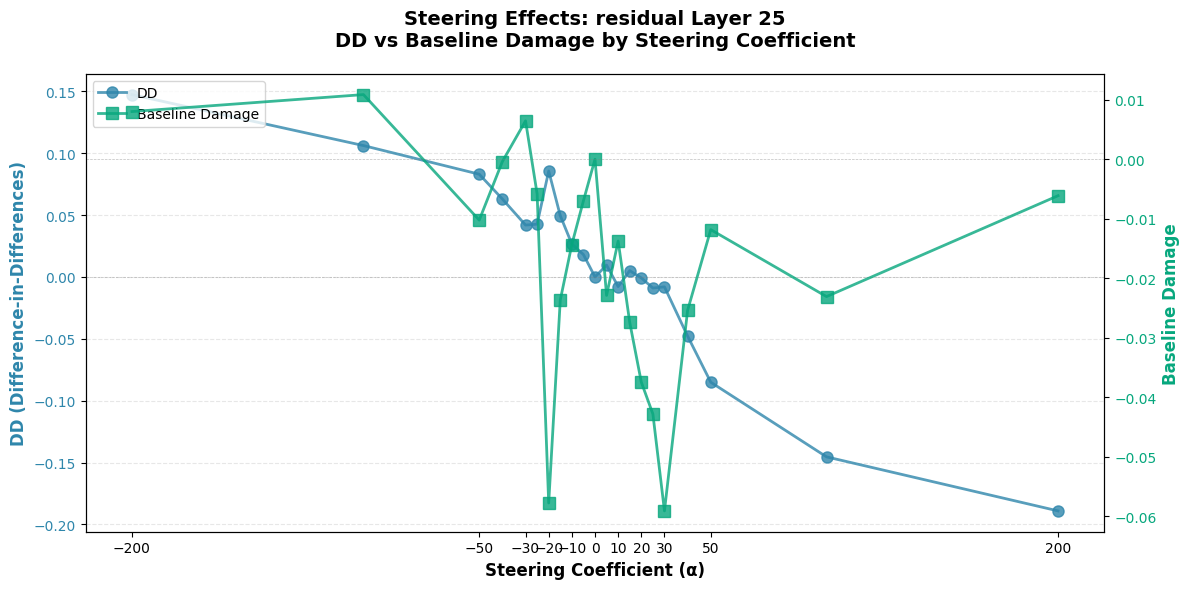


Loaded 21 steering experiments from steering_vs_ablation_metrics/residual_L25_n100.jsonl
Location: residual, Layer: 25

Alpha range: -200.0 to 200.0
DD range: -0.189 to +0.147
Baseline damage range: -0.059 to +0.011


In [90]:
# ============================================================================
# VISUALIZATION: Steering Effects - Alpha vs DD and Baseline Damage
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import json

def plot_steering_effects(jsonl_file, alphas=None):
    """
    Visualize steering effects from a JSONL file.
    
    Args:
        jsonl_file: Path to JSONL file containing steering results
        alphas: Optional list of specific alpha values to plot. If None, plots all.
    """
    # Load data from JSONL file
    data = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    
    if not data:
        print(f"No data found in {jsonl_file}")
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Filter by specific alpha values if provided
    if alphas is not None:
        df = df[df['alpha'].isin(alphas)]
        if df.empty:
            print(f"No data found for specified alphas {alphas} in {jsonl_file}")
            return
    
    # Sort by alpha for proper line plotting
    df = df.sort_values('alpha')
    
    # Extract location info for title
    location_type = df.iloc[0]['location_type']
    layer_idx = int(df.iloc[0]['layer_idx'])
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot DD (left y-axis)
    color_dd = '#2E86AB'
    ax1.set_xlabel('Steering Coefficient (α)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('DD (Difference-in-Differences)', fontsize=12, fontweight='bold', color=color_dd)
    line1 = ax1.plot(df['alpha'], df['mean_DD'], marker='o', color=color_dd,
                     linewidth=2, markersize=8, label='DD', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color_dd)
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    # Set x-axis limits to include all data points
    alpha_min = df['alpha'].min()
    alpha_max = df['alpha'].max()
    alpha_padding = (alpha_max - alpha_min) * 0.05 if alpha_max != alpha_min else 1
    ax1.set_xlim(alpha_min - alpha_padding, alpha_max + alpha_padding)
    # Set x-axis ticks to include endpoints
    # Set x-axis ticks to include all alpha values (ensures endpoints are labeled)
    unique_alphas = sorted(df['alpha'].unique())
    # If too many ticks, show every Nth value but always include endpoints
    if len(unique_alphas) > 15:
        step = max(1, len(unique_alphas) // 10)
        ax1_ticks = unique_alphas[::step]
        if unique_alphas[-1] not in ax1_ticks:
            ax1_ticks = list(ax1_ticks) + [unique_alphas[-1]]
    else:
        ax1_ticks = unique_alphas
    ax1.set_xticks(ax1_ticks)
    ax1.set_xticks(ax1_ticks)
    
    # Plot baseline damage (right y-axis)
    ax2 = ax1.twinx()
    color_damage = '#06A77D'
    ax2.set_ylabel('Baseline Damage', fontsize=12, fontweight='bold', color=color_damage)
    line2 = ax2.plot(df['alpha'], df['mean_baseline_damage'], marker='s', color=color_damage,
                     linewidth=2, markersize=8, label='Baseline Damage', alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color_damage)
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Title
    title = f'Steering Effects: {location_type} Layer {layer_idx}\nDD vs Baseline Damage by Steering Coefficient'
    if alphas is not None:
        title += f' (α ∈ {alphas})'
    ax1.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nLoaded {len(df)} steering experiments from {jsonl_file}")
    print(f"Location: {location_type}, Layer: {layer_idx}")
    if alphas is not None:
        print(f"Filtered to alphas: {alphas}")
    print(f"\nAlpha range: {df['alpha'].min():.1f} to {df['alpha'].max():.1f}")
    print(f"DD range: {df['mean_DD'].min():+.3f} to {df['mean_DD'].max():+.3f}")
    print(f"Baseline damage range: {df['mean_baseline_damage'].min():+.3f} to {df['mean_baseline_damage'].max():+.3f}")

# ============================================================================
# UNCOMMENT AND MODIFY BELOW TO LOAD AND VISUALIZE STEERING RESULTS
# ============================================================================
# Example usage - plot all alphas:
# plot_steering_effects("steering_vs_ablation_metrics/residual_L25_n100.jsonl")

# Example usage - plot specific alphas:
plot_steering_effects("steering_vs_ablation_metrics/residual_L25_n100.jsonl")
# plot_steering_effects("steering_vs_ablation_metrics/residual_L20_n100.jsonl", alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
# plot_steering_effects("steering_vs_ablation_metrics/residual_L15_n100.jsonl", alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
# plot_steering_effects("steering_vs_ablation_metrics/residual_L10_n100.jsonl", alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
# plot_steering_effects("steering_vs_ablation_metrics/residual_L5_n100.jsonl", alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
# plot_steering_effects("steering_vs_ablation_metrics/mlp_L9_n100.jsonl", alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])




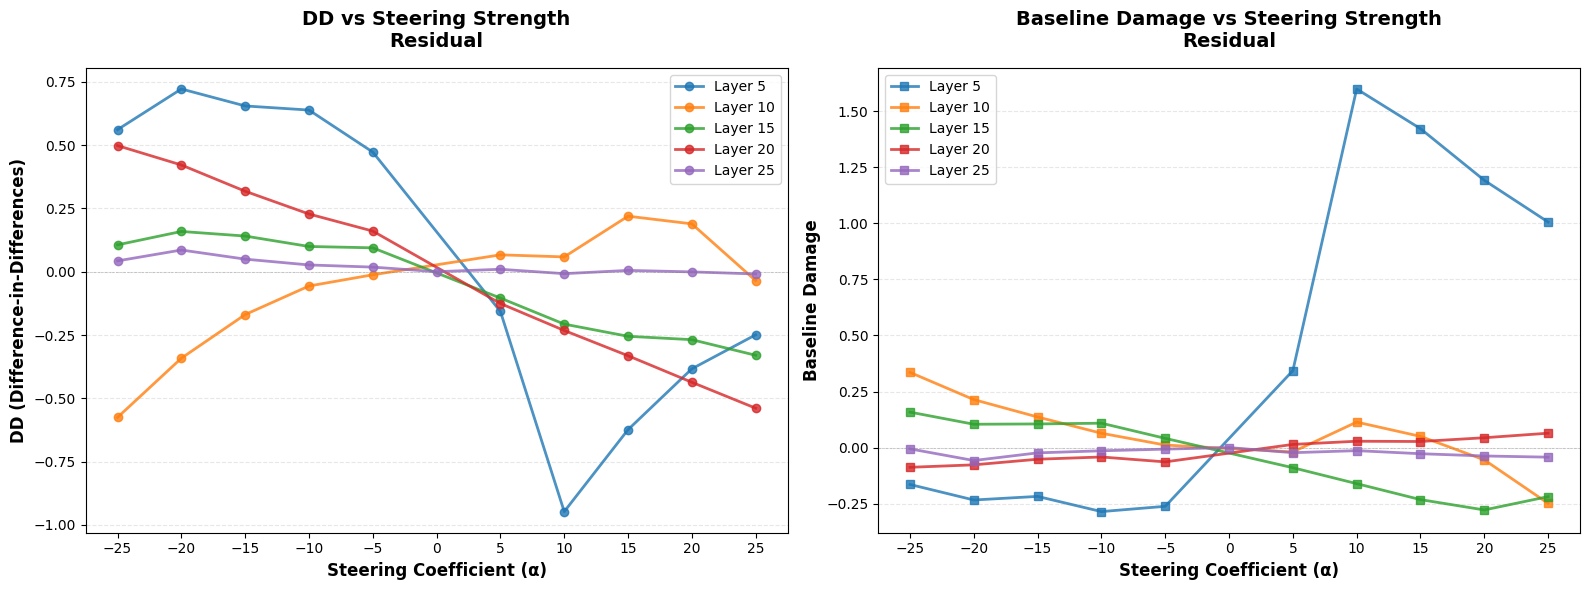

In [89]:
def plot_steering_across_layers(jsonl_files, alphas=None, location_type=None, max_xticks=11):
    import glob as glob_module

    # Handle glob pattern or list of files
    if isinstance(jsonl_files, str):
        if '*' in jsonl_files or '?' in jsonl_files:
            file_list = sorted(glob_module.glob(jsonl_files))
        else:
            file_list = [jsonl_files]
    else:
        file_list = jsonl_files

    if not file_list:
        print(f"No files found matching: {jsonl_files}")
        return

    # Load all data
    all_data = []
    for jsonl_file in file_list:
        try:
            with open(jsonl_file, "r") as f:
                for line in f:
                    all_data.append(json.loads(line))
        except Exception as e:
            print(f"Warning: Could not load {jsonl_file}: {e}")
            continue

    if not all_data:
        print("No data found in any files")
        return

    df = pd.DataFrame(all_data)

    # Filter by location_type
    if location_type is None:
        location_type = df.iloc[0]["location_type"]
    df = df[df["location_type"] == location_type]

    # Filter by alpha values
    if alphas is not None:
        df = df[df["alpha"].isin(alphas)]
        if df.empty:
            print(f"No data found for specified alphas {alphas}")
            return

    unique_alphas = sorted(df["alpha"].unique())
    layers = sorted(df["layer_idx"].unique())

    alpha_min, alpha_max = min(unique_alphas), max(unique_alphas)
    alpha_padding = (alpha_max - alpha_min) * 0.05 if alpha_max != alpha_min else 1

    def _choose_ticks(vals, max_ticks):
        vals = list(vals)
        n = len(vals)
        if n <= max_ticks:
            return vals
        step = int(np.ceil((n - 1) / (max_ticks - 1)))  # ensures we can include endpoint
        ticks = vals[::step]
        if ticks[-1] != vals[-1]:
            ticks.append(vals[-1])
        return ticks

    xticks = _choose_ticks(unique_alphas, max_xticks)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    colors = plt.cm.tab10(range(len(layers)))

    # DD plot
    for i, layer in enumerate(layers):
        df_layer = df[df["layer_idx"] == layer].sort_values("alpha")
        ax1.plot(
            df_layer["alpha"], df_layer["mean_DD"],
            marker="o", linewidth=2, markersize=6,
            label=f"Layer {int(layer)}", color=colors[i], alpha=0.8
        )

    ax1.set_xlabel("Steering Coefficient (α)", fontsize=12, fontweight="bold")
    ax1.set_ylabel("DD (Difference-in-Differences)", fontsize=12, fontweight="bold")
    ax1.set_title(f"DD vs Steering Strength\n{location_type.capitalize()}", fontsize=14, fontweight="bold", pad=15)
    ax1.axhline(0, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    ax1.grid(axis="y", alpha=0.3, linestyle="--")
    ax1.set_xlim(alpha_min - alpha_padding, alpha_max + alpha_padding)
    ax1.set_xticks(xticks)
    ax1.legend(loc="best", fontsize=10)

    # Baseline damage plot
    for i, layer in enumerate(layers):
        df_layer = df[df["layer_idx"] == layer].sort_values("alpha")
        ax2.plot(
            df_layer["alpha"], df_layer["mean_baseline_damage"],
            marker="s", linewidth=2, markersize=6,
            label=f"Layer {int(layer)}", color=colors[i], alpha=0.8
        )

    ax2.set_xlabel("Steering Coefficient (α)", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Baseline Damage", fontsize=12, fontweight="bold")
    ax2.set_title(f"Baseline Damage vs Steering Strength\n{location_type.capitalize()}", fontsize=14, fontweight="bold", pad=15)
    ax2.axhline(0, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    ax2.grid(axis="y", alpha=0.3, linestyle="--")
    ax2.set_xlim(alpha_min - alpha_padding, alpha_max + alpha_padding)
    ax2.set_xticks(xticks)
    ax2.legend(loc="best", fontsize=10)

    plt.tight_layout()
    plt.show()

plot_steering_across_layers(
    "steering_vs_ablation_metrics/residual_L*_n100.jsonl",
    alphas=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
)

## Control: Random Unit Vector Ablation

Compare layer 20 ablation results with a random unit vector to verify that the steering vector has specific effects, not just any random direction.

Loaded 10 real steering results
Running random vector steering at residual L20 for alphas: [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]...


Random vector steering: 100%|██████████| 11/11 [02:16<00:00, 12.42s/it]


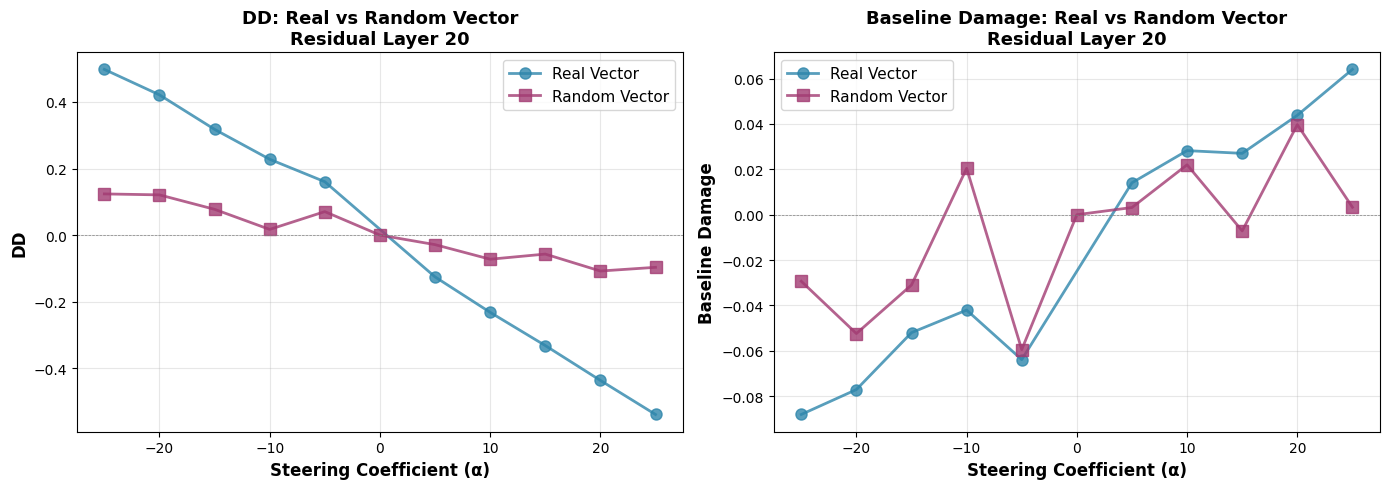

In [108]:
# Random unit vector steering control - compare across all alpha values
import torch.nn.functional as F
import glob

# Load existing steering results for layer 20
layer_idx = 20
location_type = "residual"
alphas = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]

# Load real steering results
real_results = []
for alpha in alphas:
    jsonl_file = f"steering_vs_ablation_metrics/{location_type}_L{layer_idx}_n100.jsonl"
    try:
        with open(jsonl_file, 'r') as f:
            for line in f:
                data = json.loads(line)
                if abs(data['alpha'] - alpha) < 0.1:  # Allow small float differences
                    real_results.append(data)
                    break
    except:
        continue

if not real_results:
    print(f"No steering results found for {location_type} L{layer_idx}")
else:
    print(f"Loaded {len(real_results)} real steering results")
    
    # Generate random unit vector
    steering_vector, _ = load_steering_vector(location_type, layer_idx)
    if steering_vector is None:
        print(f"No steering vector for {location_type} L{layer_idx}")
    else:
        random_vector = F.normalize(torch.randn(steering_vector.shape[0], device=steering_vector.device), p=2, dim=0)
        print(f"Running random vector steering at {location_type} L{layer_idx} for alphas: {alphas}...")
        
        random_results = []
        
        for alpha in tqdm(alphas, desc="Random vector steering"):
            alpha_results = []
            
            for tp in target_problems[:100]:
                baseline_ids = tok.encode(tp["baseline_prompt"], add_special_tokens=False)
                hint_ids = tok.encode(tp["hint_prompt"], add_special_tokens=False)
                baseline_pos = compute_readout_pos(tp["baseline_prompt"])
                hint_pos = compute_readout_pos(tp["hint_prompt"])
                
                # No intervention
                clear_all_hooks()
                baseline = compute_answer_logprobs(baseline_ids, tp["correct_answer"], None)
                hint = compute_answer_logprobs(hint_ids, tp["correct_answer"], tp["hint_value"])
                
                # Steering with random vector
                def steer_random(module, args):
                    h = args[0].clone()
                    if baseline_pos is not None:
                        h[:, baseline_pos, :] += alpha * random_vector.to(h.device)
                    return (h,) + args[1:]
                
                clear_all_hooks()
                handle = model.model.layers[layer_idx].register_forward_pre_hook(steer_random)
                baseline_steer = compute_answer_logprobs(baseline_ids, tp["correct_answer"], None)
                handle.remove()
                
                def steer_random_hint(module, args):
                    h = args[0].clone()
                    if hint_pos is not None:
                        h[:, hint_pos, :] += alpha * random_vector.to(h.device)
                    return (h,) + args[1:]
                
                clear_all_hooks()
                handle = model.model.layers[layer_idx].register_forward_pre_hook(steer_random_hint)
                hint_steer = compute_answer_logprobs(hint_ids, tp["correct_answer"], tp["hint_value"])
                handle.remove()
                
                alpha_results.append({
                    "delta_baseline": baseline["delta"],
                    "delta_hint": hint["delta"],
                    "delta_baseline_int": baseline_steer["delta"],
                    "delta_hint_int": hint_steer["delta"],
                })
            
            compute_metrics(alpha_results)
            
            random_results.append({
                "alpha": alpha,
                "mean_DD": np.mean([r["DD"] for r in alpha_results]),
                "mean_baseline_damage": np.mean([r["baseline_damage"] for r in alpha_results]),
                "mean_E_hint": np.mean([r["E_hint"] for r in alpha_results]),
            })
        
        # Visualization: compare across alphas
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        real_alphas = [r["alpha"] for r in real_results]
        real_DD = [r["mean_DD"] for r in real_results]
        real_damage = [r["mean_baseline_damage"] for r in real_results]
        
        random_alphas = [r["alpha"] for r in random_results]
        random_DD = [r["mean_DD"] for r in random_results]
        random_damage = [r["mean_baseline_damage"] for r in random_results]
        
        # DD comparison
        ax1.plot(real_alphas, real_DD, marker='o', linewidth=2, markersize=8, label='Real Vector', color='#2E86AB', alpha=0.8)
        ax1.plot(random_alphas, random_DD, marker='s', linewidth=2, markersize=8, label='Random Vector', color='#A23B72', alpha=0.8)
        ax1.set_xlabel('Steering Coefficient (α)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('DD', fontsize=12, fontweight='bold')
        ax1.set_title(f'DD: Real vs Random Vector\n{location_type.capitalize()} Layer {layer_idx}', fontsize=13, fontweight='bold')
        ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # Baseline damage comparison
        ax2.plot(real_alphas, real_damage, marker='o', linewidth=2, markersize=8, label='Real Vector', color='#2E86AB', alpha=0.8)
        ax2.plot(random_alphas, random_damage, marker='s', linewidth=2, markersize=8, label='Random Vector', color='#A23B72', alpha=0.8)
        ax2.set_xlabel('Steering Coefficient (α)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Baseline Damage', fontsize=12, fontweight='bold')
        ax2.set_title(f'Baseline Damage: Real vs Random Vector\n{location_type.capitalize()} Layer {layer_idx}', fontsize=13, fontweight='bold')
        ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


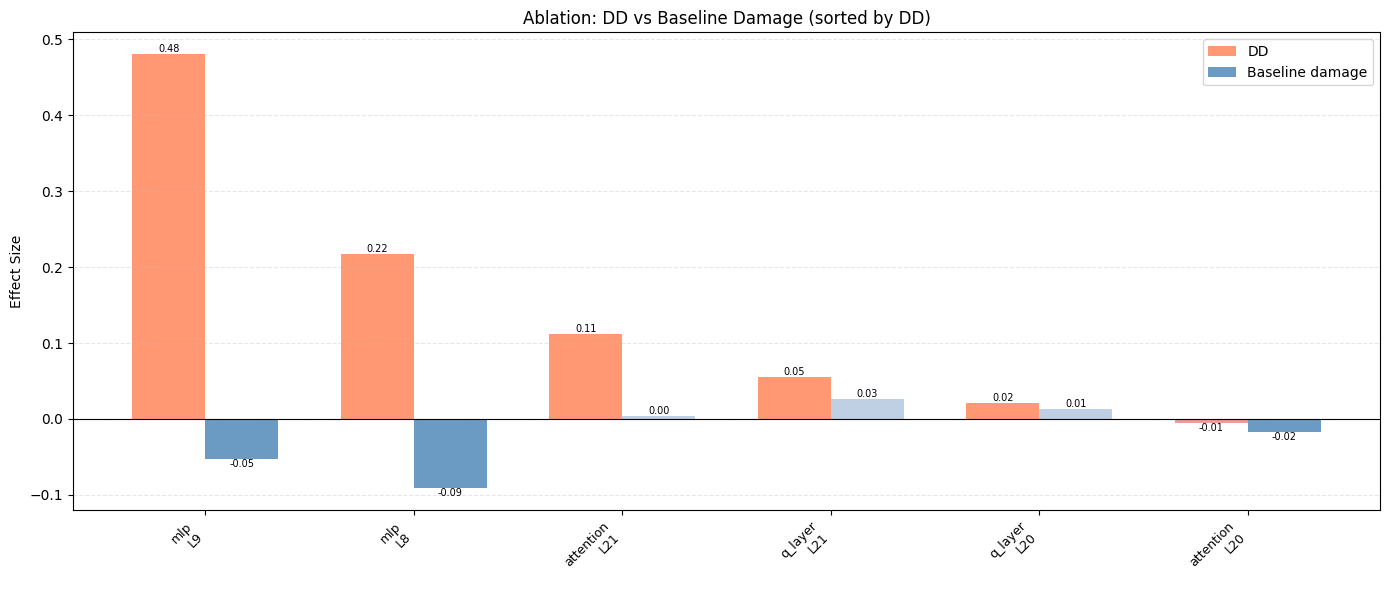

In [94]:
# Plot ablation summary
# Examples:
# plot_ablation_summary(df_ablation)  # All ablation results
# plot_ablation_summary(df_ablation, location_types=['residual'])  # Only residual
# plot_ablation_summary(df_ablation, location_types=['q_layer'], layers=[5, 10, 15])  # q_layer at specific layers
# plot_ablation_summary(df_ablation, layers=[20, 21, 22])  # All location types at these layers
# plot_ablation_summary(df_ablation, location_layer_map={'mlp': [8, 9], 'q_layer': [20, 21]})  # Different layers for different types
df_ablation = pd.DataFrame(ablation_summaries)
plot_ablation_summary(df_ablation)


## Hint-Matters Subset Analysis

On the hint-matters subset, we quantify:
1. How much the hint shifts the confidence margin (log P(correct) - max log P(wrong))
2. How often it flips the model from wrong to right in the candidate set

This analysis uses the original 200 problems with logprobs data.

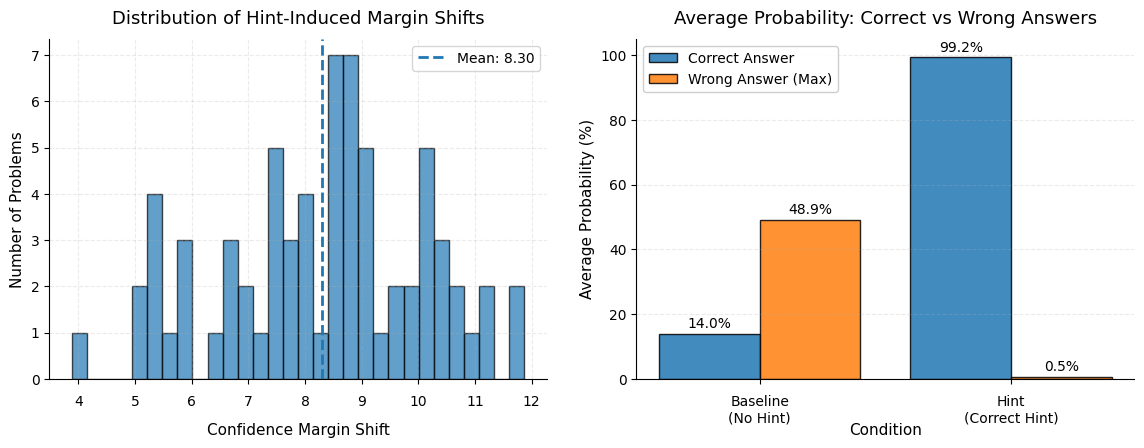

In [ ]:
# =========================
# FULL CODE (less bold + smaller titles + aligned)
# =========================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LOGPROBS_FILE_200 = "hint_experiments/gsm8k_hint_experiment_n200_tok512_logprobs.jsonl"

# -------------------------
# Load + group
# -------------------------
rollouts_200 = []
with open(LOGPROBS_FILE_200, "r") as f:
    for line in f:
        rollouts_200.append(json.loads(line))

by_problem_200 = {}
for r in rollouts_200:
    idx = r["problem_idx"]
    variant_idx = r.get("variant_idx", None)
    by_problem_200.setdefault((idx, variant_idx), {})
    by_problem_200[(idx, variant_idx)][r["mode"]] = r

# -------------------------
# Filter hint-matters subset
# -------------------------
hint_matters = []
for (idx, variant_idx), modes in by_problem_200.items():
    if "baseline" not in modes or "hint_correct_silent" not in modes:
        continue

    baseline = modes["baseline"]
    hint = modes["hint_correct_silent"]
    correct_answer = baseline["correct_answer"]

    # Filter: same digit count for answer +/- 2
    answer_digits = len(str(correct_answer))
    offsets = [-2, -1, 1, 2]
    if not all(len(str(correct_answer + o)) == answer_digits and (correct_answer + o) > 0 for o in offsets):
        continue

    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    if baseline_cp is None or hint_cp is None:
        continue

    baseline_probs = baseline_cp["cand_softmax"]
    hint_probs = hint_cp["cand_softmax"]

    # Exclude "hint" candidate if present
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    hint_nonhint = {k: v for k, v in hint_probs.items() if k != "hint"}

    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0]
    hint_best = max(hint_nonhint.items(), key=lambda x: x[1])[0]

    # baseline wrong, hint correct
    if baseline_best != "correct" and hint_best == "correct":
        baseline_margin = baseline_cp["logp_correct"] - baseline_cp["logp_wrong_max"]
        hint_margin = hint_cp["logp_correct"] - hint_cp["logp_wrong_max"]

        hint_matters.append({
            "problem_idx": idx,
            "variant_idx": variant_idx,
            "baseline_best": baseline_best,
            "hint_best": hint_best,
            "baseline_margin": baseline_margin,
            "hint_margin": hint_margin,
            "margin_shift": hint_margin - baseline_margin,
        })

df_hint_matters = pd.DataFrame(hint_matters)

# -------------------------
# Styling knobs (less bold, smaller titles)
# -------------------------
TITLE_FONTSIZE = 13
LABEL_FONTSIZE = 11
TICK_FONTSIZE = 10

TITLE_Y = 1.02
XLABEL_Y = -0.13

WSPACE = 0.18
TOP = 0.88
BOTTOM = 0.20

# -------------------------
# Make plots (manual layout for perfect alignment)
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.subplots_adjust(wspace=WSPACE, top=TOP, bottom=BOTTOM)

# ---- Left: histogram of margin shifts ----
ax0 = axes[0]
ax0.hist(df_hint_matters["margin_shift"], bins=30, alpha=0.7, edgecolor="black")
mean_shift = df_hint_matters["margin_shift"].mean()
ax0.axvline(mean_shift, linestyle="--", linewidth=2, label=f"Mean: {mean_shift:.2f}")

ax0.set_xlabel("Confidence Margin Shift", fontsize=LABEL_FONTSIZE)
ax0.set_ylabel("Number of Problems", fontsize=LABEL_FONTSIZE)
ax0.set_title(
    "Distribution of Hint-Induced Margin Shifts",
    fontsize=TITLE_FONTSIZE, y=TITLE_Y
)
ax0.legend(fontsize=10)
ax0.grid(alpha=0.25, linestyle="--")
ax0.tick_params(labelsize=TICK_FONTSIZE)

# ---- Right: avg probs correct vs wrong ----
ax1 = axes[1]

baseline_correct_probs, baseline_wrong_probs = [], []
hint_correct_probs, hint_wrong_probs = [], []

for _, row in df_hint_matters.iterrows():
    key = (row["problem_idx"], row["variant_idx"])
    baseline = by_problem_200[key]["baseline"]
    hint = by_problem_200[key]["hint_correct_silent"]

    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    if not (baseline_cp and hint_cp):
        continue

    bp = baseline_cp["cand_softmax"]
    hp = hint_cp["cand_softmax"]

    baseline_correct_probs.append(bp.get("correct", 0.0))
    baseline_wrong_probs.append(max(bp.get(k, 0.0) for k in bp.keys() if k != "correct"))

    hint_correct_probs.append(hp.get("correct", 0.0))
    hint_wrong_probs.append(max(hp.get(k, 0.0) for k in hp.keys() if k != "correct"))

baseline_avg_correct = float(np.mean(baseline_correct_probs) * 100)
baseline_avg_wrong   = float(np.mean(baseline_wrong_probs) * 100)
hint_avg_correct     = float(np.mean(hint_correct_probs) * 100)
hint_avg_wrong       = float(np.mean(hint_wrong_probs) * 100)

x = np.arange(2)
width = 0.40

correct_probs = [baseline_avg_correct, hint_avg_correct]
wrong_probs   = [baseline_avg_wrong, hint_avg_wrong]

bars1 = ax1.bar(x - width/2, correct_probs, width, label="Correct Answer",
                alpha=0.85, edgecolor="black", linewidth=1.0)
bars2 = ax1.bar(x + width/2, wrong_probs, width, label="Wrong Answer (Max)",
                alpha=0.85, edgecolor="black", linewidth=1.0)

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%",
                 ha="center", va="bottom", fontsize=10)

ax1.set_xlabel("Condition", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Average Probability (%)", fontsize=LABEL_FONTSIZE)
ax1.set_title(
    "Average Probability: Correct vs Wrong Answers",
    fontsize=TITLE_FONTSIZE, y=TITLE_Y
)

ax1.set_xticks(x)
ax1.set_xticklabels(["Baseline\n(No Hint)", "Hint\n(Correct Hint)"], fontsize=TICK_FONTSIZE)

# Sane percent range
ax1.set_ylim(0, 105)

ax1.legend(loc="upper left", fontsize=10, framealpha=0.95)
ax1.grid(axis="y", alpha=0.25, linestyle="--", linewidth=0.8)
ax1.tick_params(labelsize=TICK_FONTSIZE)

# -------------------------
# Global alignment + remove top/right spines
# -------------------------
for ax in axes:
    ax.xaxis.set_label_coords(0.5, XLABEL_Y)     # align x-label heights
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", pad=8)

plt.show()


In [ ]:
# Plot ablation vs steering comparison for each location type (run after steering is done)
# for loc_type in ["q_layer", "attention", "mlp", "residual"]:
#     plot_intervention_comparison(df_summary, loc_type, "mean_DD")

In [ ]:
def plot_selectivity(df):
    """
    Plot DD vs baseline damage to show selectivity.
    Good interventions: high DD, low baseline damage.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot ablation
    df_abl = df[df["intervention_type"] == "ablation"]
    for loc_type in df_abl["location_type"].unique():
        df_loc = df_abl[df_abl["location_type"] == loc_type]
        ax.scatter(
            df_loc["mean_baseline_damage"],
            df_loc["mean_DD"],
            s=100,
            marker="s",
            label=f"{loc_type} (abl)",
            alpha=0.7
        )
        # Annotate with layer
        for _, row in df_loc.iterrows():
            ax.annotate(
                f"L{int(row['layer_idx'])}",
                (row["mean_baseline_damage"], row["mean_DD"]),
                fontsize=8
            )
    
    # Plot best steering (alpha with best DD/baseline_damage ratio)
    df_steer = df[df["intervention_type"] == "steering"]
    for loc_type in df_steer["location_type"].unique():
        for layer in df_steer[df_steer["location_type"] == loc_type]["layer_idx"].unique():
            df_layer = df_steer[(df_steer["location_type"] == loc_type) & (df_steer["layer_idx"] == layer)]
            # Find best alpha (highest DD with lowest baseline damage)
            best_idx = (df_layer["mean_DD"] - df_layer["mean_baseline_damage"]).idxmax()
            best = df_layer.loc[best_idx]
            ax.scatter(
                best["mean_baseline_damage"],
                best["mean_DD"],
                s=100,
                marker="^",
                alpha=0.7
            )
            ax.annotate(
                f"{loc_type} L{int(layer)} α={best['alpha']}",
                (best["mean_baseline_damage"], best["mean_DD"]),
                fontsize=7
            )
    
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.5)
    ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.5)
    
    ax.set_xlabel("Baseline Damage (lower = better)")
    ax.set_ylabel("DD (higher = more selective)")
    ax.set_title("Intervention Selectivity: DD vs Baseline Damage\n(squares=ablation, triangles=best steering)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_selectivity(df_summary)

In [ ]:
def plot_accuracy_comparison(df):
    """
    Plot accuracy changes under different interventions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Group by intervention type
    df_abl = df[df["intervention_type"] == "ablation"].copy()
    
    # Left: Ablation accuracy changes
    ax = axes[0]
    if not df_abl.empty:
        x = range(len(df_abl))
        width = 0.35
        
        # Baseline accuracy change
        baseline_change = df_abl["acc_baseline_int"] - df_abl["acc_baseline"]
        hint_change = df_abl["acc_hint_int"] - df_abl["acc_hint"]
        
        labels = [f"{row['location_type']}\nL{int(row['layer_idx'])}" for _, row in df_abl.iterrows()]
        
        ax.bar([i - width/2 for i in x], baseline_change, width, label="Baseline", color="steelblue", alpha=0.7)
        ax.bar([i + width/2 for i in x], hint_change, width, label="Hint", color="coral", alpha=0.7)
        ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
        ax.set_ylabel("Accuracy Change")
        ax.set_title("Ablation: Accuracy Change")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
        ax.legend()
    
    # Right: Summary stats
    ax = axes[1]
    
    # Create summary table
    summary_data = []
    for int_type in ["ablation", "steering"]:
        df_int = df[df["intervention_type"] == int_type]
        if not df_int.empty:
            summary_data.append({
                "Intervention": int_type,
                "Avg Baseline Acc": f"{df_int['acc_baseline'].mean():.1%}",
                "Avg Hint Acc": f"{df_int['acc_hint'].mean():.1%}",
                "Avg Baseline+Int Acc": f"{df_int['acc_baseline_int'].mean():.1%}",
                "Avg Hint+Int Acc": f"{df_int['acc_hint_int'].mean():.1%}",
            })
    
    if summary_data:
        ax.axis("off")
        table = ax.table(
            cellText=[[d[k] for k in ["Intervention", "Avg Baseline Acc", "Avg Hint Acc", "Avg Baseline+Int Acc", "Avg Hint+Int Acc"]] for d in summary_data],
            colLabels=["Intervention", "Baseline", "Hint", "Baseline+Int", "Hint+Int"],
            loc="center",
            cellLoc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax.set_title("Average Accuracies")
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_accuracy_comparison(df_summary)

In [ ]:
def print_best_interventions(df, top_k=10):
    """
    Print the best interventions by DD and selectivity.
    """
    print("=" * 80)
    print("TOP INTERVENTIONS BY DD (hint-specific effect)")
    print("=" * 80)
    
    df_sorted = df.sort_values("mean_DD", ascending=False).head(top_k)
    for _, row in df_sorted.iterrows():
        alpha_str = f" α={row['alpha']}" if row['alpha'] is not None else ""
        print(f"{row['intervention_type']:10} {row['location_type']:15} L{int(row['layer_idx']):2}{alpha_str:10} | "
              f"DD={row['mean_DD']:+.3f}  baseline_dmg={row['mean_baseline_damage']:+.3f}  "
              f"hint_dmg={row['mean_hint_damage']:+.3f}")
    
    print("\n" + "=" * 80)
    print("TOP INTERVENTIONS BY SELECTIVITY (high DD, low baseline damage)")
    print("=" * 80)
    
    # Selectivity score: DD - abs(baseline_damage)
    df["selectivity"] = df["mean_DD"] - df["mean_baseline_damage"].abs()
    df_sorted = df.sort_values("selectivity", ascending=False).head(top_k)
    
    for _, row in df_sorted.iterrows():
        alpha_str = f" α={row['alpha']}" if row['alpha'] is not None else ""
        print(f"{row['intervention_type']:10} {row['location_type']:15} L{int(row['layer_idx']):2}{alpha_str:10} | "
              f"DD={row['mean_DD']:+.3f}  baseline_dmg={row['mean_baseline_damage']:+.3f}  "
              f"selectivity={row['selectivity']:+.3f}")

In [ ]:
print_best_interventions(df_summary)

## 7. Dashboard Summary

In [ ]:
def print_dashboard(df):
    """
    Print a comprehensive metrics dashboard.
    """
    print("\n" + "=" * 100)
    print(" " * 35 + "METRICS DASHBOARD")
    print("=" * 100)
    
    # Overall statistics
    print("\n[1] BASELINE PHENOMENON (no intervention)")
    print("-" * 50)
    print(f"  Mean Δ_baseline:       {df['mean_delta_baseline'].iloc[0]:+.3f}")
    print(f"  Mean Δ_hint:           {df['mean_delta_hint'].iloc[0]:+.3f}")
    print(f"  Mean E_hint:           {df['mean_E_hint'].iloc[0]:+.3f}")
    print(f"  Baseline accuracy:     {df['acc_baseline'].iloc[0]:.1%}")
    print(f"  Hint accuracy:         {df['acc_hint'].iloc[0]:.1%}")
    
    print("\n[2] ABLATION EFFECTS")
    print("-" * 50)
    df_abl = df[df["intervention_type"] == "ablation"]
    if not df_abl.empty:
        for _, row in df_abl.iterrows():
            print(f"  {row['location_type']:15} L{int(row['layer_idx']):2} | "
                  f"DD={row['mean_DD']:+.3f}  base_dmg={row['mean_baseline_damage']:+.3f}  "
                  f"acc_base={row['acc_baseline_int']:.1%}  acc_hint={row['acc_hint_int']:.1%}")
    
    print("\n[3] BEST STEERING CONFIGS (per location/layer)")
    print("-" * 50)
    df_steer = df[df["intervention_type"] == "steering"]
    if not df_steer.empty:
        for loc_type in df_steer["location_type"].unique():
            for layer in df_steer[df_steer["location_type"] == loc_type]["layer_idx"].unique():
                df_layer = df_steer[(df_steer["location_type"] == loc_type) & (df_steer["layer_idx"] == layer)]
                # Best by DD
                best = df_layer.loc[df_layer["mean_DD"].idxmax()]
                print(f"  {loc_type:15} L{int(layer):2} | best α={best['alpha']:+.1f} | "
                      f"DD={best['mean_DD']:+.3f}  base_dmg={best['mean_baseline_damage']:+.3f}")
    
    print("\n[4] KEY FINDINGS")
    print("-" * 50)
    
    # Find best overall ablation
    if not df_abl.empty:
        best_abl = df_abl.loc[df_abl["mean_DD"].idxmax()]
        print(f"  Best ablation: {best_abl['location_type']} L{int(best_abl['layer_idx'])} (DD={best_abl['mean_DD']:+.3f})")
    
    # Find best overall steering
    if not df_steer.empty:
        best_steer = df_steer.loc[df_steer["mean_DD"].idxmax()]
        print(f"  Best steering: {best_steer['location_type']} L{int(best_steer['layer_idx'])} α={best_steer['alpha']} (DD={best_steer['mean_DD']:+.3f})")
    
    print("\n" + "=" * 100)

In [ ]:
print_dashboard(df_summary)

In [ ]:
# Save results
df_summary.to_csv("ablation_vs_steering_summary.csv", index=False)
print("Saved summary to ablation_vs_steering_summary.csv")

# Save full results
with open("ablation_vs_steering_full.json", "w") as f:
    json.dump(all_results, f, indent=2)
print("Saved full results to ablation_vs_steering_full.json")